# MainQuest2

## 문제 1.

### 데이터 준비

In [1]:
!pip install dataset
!pip install huggingface_hub

In [2]:
import datasets
from datasets import load_dataset

In [3]:
dataset = load_dataset('nateraw/pascal-voc-2012', split = 'train')

Using custom data configuration nateraw___pascal-voc-2012-c68607404d4811ac
Reusing dataset parquet (/aiffel/.cache/huggingface/datasets/parquet/nateraw___pascal-voc-2012-c68607404d4811ac/0.0.0/9296ce43568b20d72ff8ff8ecbc821a16b68e9b8b7058805ef11f06e035f911a)


### io.bytesIO 함수를 이용해 바이트 데이터를 이미지로 변환

In [4]:
print(dataset)

Dataset({
    features: ['image', 'mask'],
    num_rows: 2913
})


In [5]:
import io
from PIL import Image

dataset_img = []
dataset_mask= []

for i in dataset['image']:
    data_b = i['bytes']
    img = io.BytesIO(data_b)
    dataset_img.append(img)
    
for i in dataset['mask']:
    data_b = i['bytes']
    mask = io.BytesIO(data_b)
    dataset_mask.append(mask)

In [6]:
dataset_1 = list(zip(dataset_img, dataset_mask))

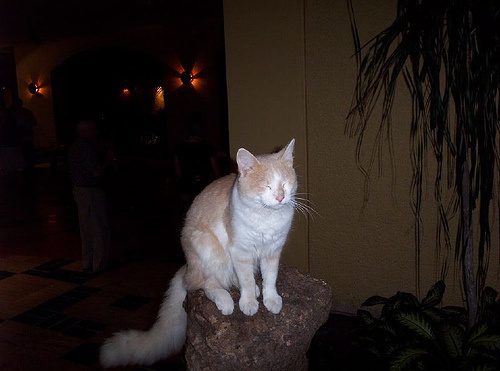

In [7]:
i = dataset_1[188][0]
Image.open(i)

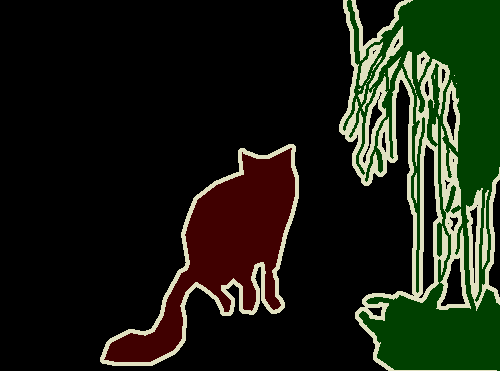

In [8]:
i = dataset_1[188][1]
Image.open(i)

In [9]:
len(dataset_1)

2913

### 데이터 전처리

In [12]:
import numpy as np

img_size = (192, 192)

dataset_img_2 = np.zeros((len(dataset_1), ) + img_size + (3, ), dtype="float32")
dataset_mask_2 = np.zeros((len(dataset_1), ) + img_size + (1, ), dtype="uint8")

a=0
for i in dataset_img:
    image = Image.open(i)
    image = image.resize(img_size)
    dataset_img_2[a] = np.array(image)
    a += 1
a=0
for i in dataset_mask:
    image = Image.open(i)
    image_gray = image.convert("L")
    image = image_gray.resize(img_size)
    dataset_mask_2[a, :, :, 0] = np.array(image)
    a +=1 

In [13]:
#6:2:2 비율로 나눔 (test 이미지는 원본으로 사용해야함)
train_input_imgs = dataset_img_2[:1747]
train_targets = dataset_mask_2[:1747]
val_input_imgs = dataset_img_2[1747:2330]
val_targets = dataset_mask_2[1747:2330]

test_input_imgs = dataset_img[2330:]
test_target_imgs = dataset_mask[2330:]

### augmentation

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

### U-net 모델 만들기

In [18]:

def UNet(pretrained_weights = None,input_size = (192, 192)):
    inputs = keras.Input(shape=img_size + (3,))
    aug = data_augmentation(inputs)
    re = layers.Rescaling(1./255)(aug)
    c1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(re)
    c1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c1)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)
    
    
    c2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(p1)
    c2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)
    
    
    c3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(p2)
    c3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(c3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)
    
    
    c4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(p3)
    c4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same')(p4)
    c5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same')(c5)


    up6 = layers.UpSampling2D(size = (2,2))(c5)
    c6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(up6)
    c6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(c6)
    dr1 = layers.Dropout(0.4)(c6)

    up7 = layers.UpSampling2D(size = (2,2))(dr1)
    c7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(up7)
    c7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(c7)
    

    up8 = layers.UpSampling2D(size = (2,2))(c7)
    c8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(up8)
    c8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c8)
    
    
    up9 = layers.UpSampling2D(size = (2,2))(c8)
    c9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(up9)
    c9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c9)
    c9 = layers.Conv2D(2, 3, activation = 'relu', padding = 'same')(c9)
    dr2 = layers.Dropout(0.4)(c9)
    c10 = layers.Conv2D(3,1, activation = 'softmax')(dr2)

    model = keras.Model(inputs = inputs, outputs=[c10])

    return model

In [19]:
model = UNet()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 192, 192, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 192, 192, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 128)       73856 

In [20]:
model.compile(optimizer = "RMSprop", loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
Model: "model"

In [21]:
callbacks =[
    keras.callbacks.ModelCheckpoint("segmentation.keras",
                                    save_best_only = True),
    keras.callbacks.TensorBoard('logs')]
history = model.fit(train_input_imgs, train_targets,
                   epochs=2,
                   callbacks=callbacks,
                   batch_size=64,
                   validation_data=(val_input_imgs, val_targets))

Epoch 1/2
28/28 [==============================] - 95s 2s/step - loss: nan - accuracy: 0.6618 - val_loss: nan - val_accuracy: 0.6995
Epoch 2/2
28/28 [==============================] - 44s 2s/step - loss: nan - accuracy: 0.6810 - val_loss: nan - val_accuracy: 0.6995


텐서보드 결과를 공유할 수 있는 url 주소 링크를
자신의 깃헙 Main_Quest_2 폴더 내의 Readme.md 파일에 게시!

In [30]:
# 텐서보드실행
%load_ext tensorboard

%tensorboard --logdir logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
!kill 903

In [31]:
%reload_ext tensorboard